In [1]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

## Useful functions

In [3]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
#
from helper import get_7dt_depth
dptbl = get_7dt_depth(exptime=180)

In [4]:
sptbl = ascii.read(f"../3.table/kn_sim_cube_v1/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_spec_2020-03-19.dat")
phtbl = ascii.read(f"../3.table/kn_sim_cube_v1/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_mags_2020-03-19.dat")

- Filterset
	- 0 : g
	- 1 : r
	- 2 : i
	- 3 : z
	- 4 : y
	- 5 : J
	- 6 : H
	- 7 : K
	- 8 : bolometric

In [5]:
phtbl[40:50]

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,col40,col41,col42,col43,col44,col45,col46,col47,col48,col49,col50,col51,col52,col53,col54,col55,col56
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
40,0.2973018,-12.3108,-12.3148,-12.3177,-12.3147,-12.3133,-12.3064,-12.3094,-12.3035,-12.3087,-12.3236,-12.3385,-12.3523,-12.3608,-12.3724,-12.3918,-12.3955,-12.4151,-12.4283,-12.4358,-12.4402,-12.4469,-12.447,-12.4601,-12.459,-12.4591,-12.4632,-12.4605,-12.4623,-12.462,-12.4623,-12.4595,-12.462,-12.4503,-12.4548,-12.4457,-12.4319,-12.4263,-12.4203,-12.4068,-12.3895,-12.3796,-12.3681,-12.355,-12.3431,-12.3283,-12.3139,-12.3131,-12.3098,-12.3169,-12.3204,-12.3218,-12.3198,-12.32,-12.313
41,0.3038118,-12.3509,-12.3521,-12.3567,-12.3538,-12.3503,-12.3447,-12.3485,-12.3402,-12.349,-12.3636,-12.3804,-12.392,-12.4016,-12.4159,-12.4341,-12.4393,-12.4576,-12.4686,-12.4784,-12.4856,-12.4916,-12.493,-12.507,-12.5068,-12.5049,-12.5094,-12.509,-12.5082,-12.511,-12.5106,-12.5069,-12.5082,-12.4972,-12.4991,-12.4893,-12.4758,-12.4698,-12.4628,-12.4492,-12.4317,-12.4207,-12.4092,-12.396,-12.3843,-12.3668,-12.3535,-12.3512,-12.3491,-12.3575,-12.3588,-12.3589,-12.3578,-12.3616,-12.3527
42,0.3104645,-12.3876,-12.3918,-12.3949,-12.3927,-12.3871,-12.3844,-12.3879,-12.381,-12.39,-12.4013,-12.4196,-12.4329,-12.4429,-12.4552,-12.4739,-12.4827,-12.5018,-12.5095,-12.5204,-12.5263,-12.5371,-12.5385,-12.5541,-12.5505,-12.5512,-12.5532,-12.5561,-12.555,-12.5576,-12.555,-12.5521,-12.5514,-12.5416,-12.5433,-12.5311,-12.5209,-12.5132,-12.5063,-12.4912,-12.4748,-12.459,-12.4494,-12.435,-12.4236,-12.4059,-12.3933,-12.3898,-12.3881,-12.3958,-12.3988,-12.4014,-12.3988,-12.4009,-12.3916
43,0.3172627,-12.4285,-12.4309,-12.4331,-12.4331,-12.426,-12.4249,-12.4262,-12.4196,-12.4311,-12.4387,-12.4582,-12.4705,-12.4842,-12.4961,-12.5144,-12.5255,-12.5433,-12.5514,-12.5629,-12.5671,-12.5797,-12.5818,-12.5935,-12.5897,-12.5899,-12.5925,-12.5984,-12.5941,-12.596,-12.5937,-12.595,-12.5899,-12.5833,-12.5855,-12.5719,-12.5622,-12.5542,-12.5463,-12.5302,-12.5165,-12.5029,-12.4897,-12.4723,-12.4616,-12.4431,-12.4328,-12.4269,-12.426,-12.4355,-12.4376,-12.4414,-12.4369,-12.4394,-12.4332
44,0.3242099,-12.4657,-12.468,-12.4695,-12.472,-12.4636,-12.4646,-12.4629,-12.4549,-12.4666,-12.4763,-12.4952,-12.5081,-12.5227,-12.5337,-12.5533,-12.565,-12.5798,-12.5897,-12.6008,-12.6042,-12.6166,-12.6194,-12.6294,-12.6272,-12.6275,-12.6293,-12.6359,-12.6313,-12.636,-12.6317,-12.631,-12.6262,-12.6184,-12.6231,-12.609,-12.6002,-12.5913,-12.5853,-12.5699,-12.5537,-12.541,-12.5279,-12.5081,-12.4983,-12.481,-12.4671,-12.4634,-12.4628,-12.4724,-12.4755,-12.4785,-12.474,-12.4744,-12.471
45,0.3313092,-12.5018,-12.5038,-12.5052,-12.5073,-12.4995,-12.5015,-12.4998,-12.4936,-12.502,-12.5155,-12.5311,-12.543,-12.5592,-12.5712,-12.5906,-12.601,-12.6174,-12.6282,-12.6371,-12.6432,-12.6523,-12.6578,-12.6667,-12.6676,-12.6634,-12.6668,-12.674,-12.6693,-12.6756,-12.6694,-12.6698,-12.6629,-12.6569,-12.6607,-12.6463,-12.6406,-12.6281,-12.6216,-12.6085,-12.5889,-12.5788,-12.5654,-12.5445,-12.5343,-12.5186,-12.504,-12.5011,-12.5013,-12.5079,-12.5124,-12.5127,-12.5094,-12.5111,-12.5062
46,0.3385639,-12.5367,-12.5401,-12.5404,-12.5439,-12.5379,-12.537,-12.5342,-12.5305,-12.5381,-12.5516,-12.5672,-12.5786,-12.5973,-12.6085,-12.6278,-12.6389,-12.6542,-12.6656,-12.6756,-12.6851,-12.6922,-12.698,-12.7047,-12.7071,-12.7042,-12.7054,-12.7152,-12.7077,-12.7158,-1

In [6]:
phtbl.meta

OrderedDict([('comments',
              ['1:iteration 2:time bin[s] 3-k:AB magnitude for k-th angular bin',
               'g-band (filter: g_LSST.dat)',
               'r-band (filter: r_LSST.dat)',
               'i-band (filter: i_LSST.dat)',
               'z-band (filter: z_LSST.dat)',
               'y-band (filter: y_LSST.dat)',
               'J-band (filter: J_2MASS.dat)',
               'H-band (filter: H_2MASS.dat)',
               'K-band (filter: Ks_mosfire.dat)',
               'S-band (filter: Spitzer_IRAC2.dat)'])])

(0.0, 5.0)

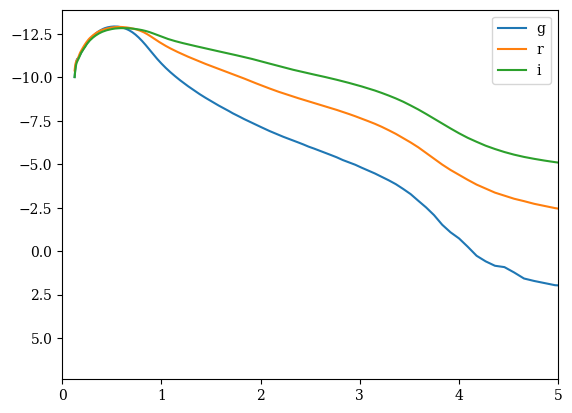

In [7]:

timebin = np.unique(phtbl['col2'])
ntimebin = len(timebin)
gg = 0
gmag = phtbl['col3'][gg:gg+ntimebin]
rr = 0+ntimebin*1
rmag = phtbl['col3'][rr:rr+ntimebin]
ii = 0+ntimebin*2
imag = phtbl['col3'][ii:ii+ntimebin]


plt.plot(timebin, gmag, label='g')
plt.plot(timebin, rmag, label='r')
plt.plot(timebin, imag, label='i')

plt.legend()
yl, yu = plt.ylim()
plt.ylim([yu, yl])
plt.xlim([0, 5])

- Spectrum
	- 1-2: wavelength bin [cm]
	- 3-56: flux into angular bin at R=10pc [erg/(s * Angstrom * cm2)]

In [8]:
#	synphot table
mglist = []
# mgtbl

times = np.array([float(sptbl.meta['comments'][i].split('= ')[-1]) for i in range(len(sptbl.meta['comments']))])
# tt = 10
# t = times[tt]
for tt, t in enumerate(times):
	step = 1024
	sptbl['lam'] = (((sptbl['col1']+sptbl['col2'])/2)*u.cm).to(u.Angstrom).value
	lam = sptbl['lam'][step*tt:step*(tt+1)]
	flam = sptbl['col3'][step*tt:step*(tt+1)]

	# sdss = speclite.filters.load_filters('sdss2010-*')
	# smags = sdss.get_ab_magnitudes(flam*(u.erg/u.second/u.Angstrom/u.cm**2), lam*u.Angstrom)
	# mglist.append(smags)
	lsst = speclite.filters.load_filters('lsst2016-*')
	lmags = lsst.get_ab_magnitudes(flam*(u.erg/u.second/u.Angstrom/u.cm**2), lam*u.Angstrom)
	mglist.append(lmags)

	# plt.plot(lam, flam)

# plt.title(f"t={t:1.3f} days")
# plt.xlim([3000, 10000])

mgtbl = vstack(mglist)
mgtbl

lsst-u,lsst-g,lsst-r,lsst-i,lsst-z,lsst-y
float64,float64,float64,float64,float64,float64
-5.638040014095662,-5.776205157306907,-6.138565385393772,-5.7677343473536,-6.172462008165327,-6.206183592632261
-6.354705294511432,-6.423275623434185,-6.535288641299713,-6.310673887925299,-6.589111043374039,-6.574956377075186
-6.639610424326042,-6.710602120680655,-6.678474255294925,-6.566060325988613,-6.794859624733975,-6.812440997863098
-6.692285180487615,-6.801413338320432,-6.84274897238756,-6.719350831019234,-6.968647415619933,-6.984586349308252
-6.770482013027948,-6.9464959122576495,-7.061792169586255,-6.919229178420284,-7.14602210689966,-7.152544744988303
-6.925860602740944,-7.11880337663123,-7.242553952828898,-7.116214048845624,-7.301707367165279,-7.311545376327805
-7.076651414386092,-7.281770848187401,-7.418682559264681,-7.270088883911856,-7.441102977934398,-7.461443915399515
-7.2343880638362865,-7.461483569327287,-7.5887418491385965,-7.427288837034091,-7.582899680253262,-7.608842369008078
-7.398877847865467,-7.638233910052423,-7.7588455168555095,-7.615917976282377,-7.710353927676233,-7.738187768922826


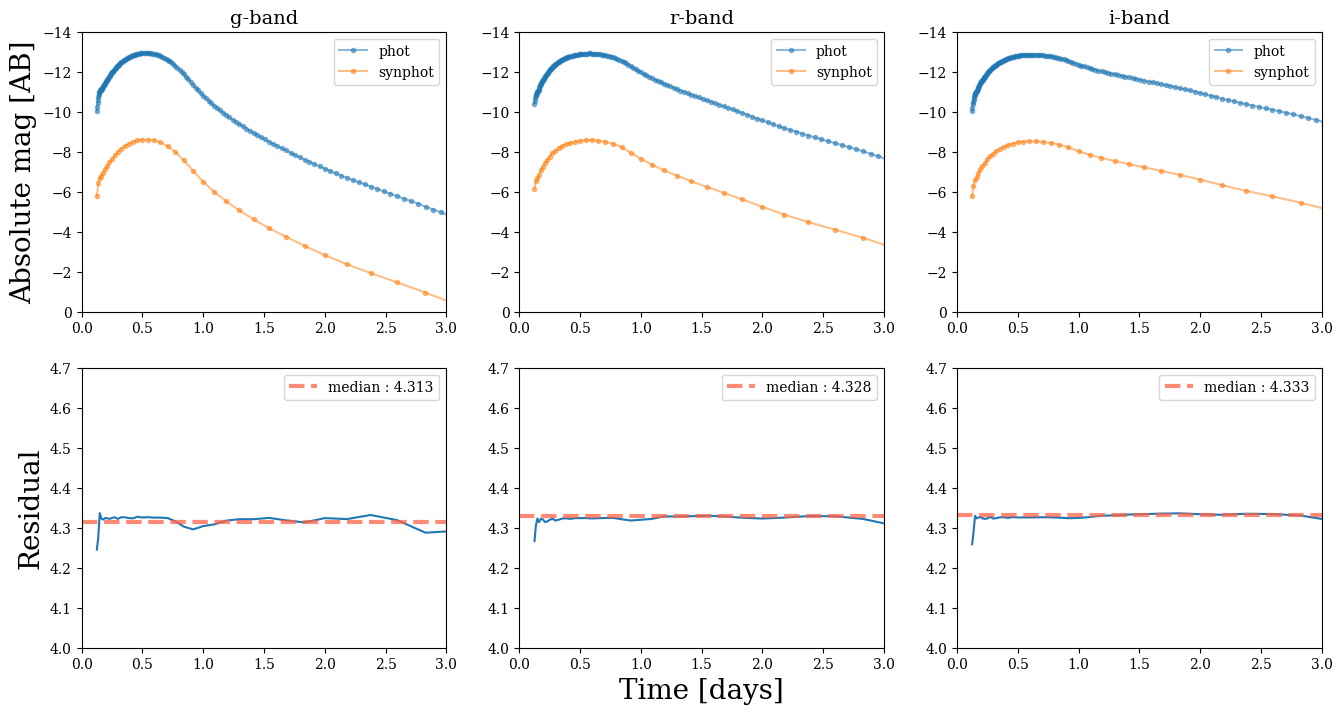

In [51]:
xl, xr = 0, 3
yl, yu = -14, 0
fig = plt.figure(figsize=(16, 8))

for jj, (filte, mag) in enumerate(zip(['g', 'r', 'i'], [gmag, rmag, imag])):

	plt.subplot(2, 3, jj+1)
	plt.title(f"{filte}-band")
	plt.plot(timebin, mag, label='phot', marker='.', alpha=0.5)
	plt.plot(times, mgtbl[f'lsst-{filte}'], label='synphot', marker='.', alpha=0.5)

	if jj==0:
		plt.ylabel('Absolute mag [AB]')
	plt.legend()
	# yl, yu = plt.ylim()
	plt.ylim([yu, yl])
	plt.xlim([xl, xr])

	plt.subplot(2, 3, jj+4)
	#	interpolated mag
	intp_mag = np.interp(times, timebin, mag,)

	# plt.plot(times, mgtbl[f'sdss2010-{filte}']-intp_mag)
	residual = mgtbl[f'lsst-{filte}']-intp_mag
	resmed = np.median(residual)

	plt.plot(times, residual)
	plt.axhline(y=resmed, ls='--', c='tomato', lw=3, alpha=0.75, label=f"median : {resmed:1.3f}")
	plt.legend()
	plt.xlim([xl, xr])
	plt.ylim([4.0, 4.7])
	if jj==0:
		plt.ylabel('Residual')
	if jj==1:
		plt.xlabel('Time [days]')

plt.savefig('../4.plot/magnitude.offset.png')


In [50]:
mean_residual = np.mean([4.313, 4.328, 4.333])
flux_ratio = 10.**(mean_residual/2.5)
flux_ratio

53.686694682238354

- calculate the conversion (flam -> fnu) by hand

In [43]:
t = times[24]
step = 1024
sptbl['lam'] = (((sptbl['col1']+sptbl['col2'])/2)*u.cm).to(u.Angstrom).value
lam = sptbl['lam'][step*tt:step*(tt+1)]
flam = sptbl['col3'][step*tt:step*(tt+1)]
fnu = convert_flam2fnu(flam*(u.erg/u.second/u.Angstrom/u.cm**2), lam*(u.Angstrom))
abmag = fnu.to(u.ABmag)

index = 400
lam[index]*u.Angstrom, flam[index]*(u.erg/u.second/u.Angstrom/u.cm**2), fnu[index], abmag[index]

# (3.369*(6670.5**2)/3)*(1e-11/1e10)*(1e-8), fnu[index]



(4.996852539075e-22, <Quantity 5.00109842e-22 erg / (cm2 Hz s)>)